In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [3]:
import seaborn as sns
import plotly
import matplotlib as plt
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as sk
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [4]:
train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')

In [5]:
item_categories.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [6]:
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [7]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
train.shape

(2935849, 6)

In [10]:
train.head(100)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
95,08.01.2013,0,25,2808,999.00,2.0
96,09.01.2013,0,25,2808,999.00,1.0
97,11.01.2013,0,25,2808,999.00,4.0
98,17.01.2013,0,25,2808,999.00,1.0


In [11]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
class ETL():
    def __init__(self, path_to_train_data, path_to_test_data):
        self.path_to_train_data = path_to_train_data
        self.path_to_test_data = path_to_test_data
        self.train = None
        self.test = None
        self.dqc = DQC(change = True, show = True, df_data = self.train)
    
    def fake_Extract(self):
        self.train = pd.read_csv(self.path_to_train_data)
        self.test = pd.read_csv(self.path_to_test_data)
    
    def Transform(self):
        #Тут DQC, но мне лень прописывать агрегацию
        pass
    
    def Load(self, file_name):
        self.train.to_csv(file_name+'.csv')

In [13]:
class DQC():
    def __init__(self, change = True, show = True, df_data = None):
        self.data = df_data
        self.change = change
        self.show = show
        
    def set_data(self, df_data):
        self.data = df_data
        
    def set_change(self, value):
        self.change = value
        
    def set_show(self, value):
        self.show = value
        
    def get_data(self):
        return self.data
    
    #Check data
    def show_comman_stats(self):
        print(f'Missing values\n{self.data.isnull().sum(axis = 0)}\n\n\n')
        print(self.data.describe().T)
        
    def boxplot(self, feature_name):
        sns.boxplot(x=self.data[feature_name])
    
    def pairplot(self, feature_list):
        sns.pairplot(data=self.data[feature_list])
    
    #Data inconsistency
    def fix_feature_by_low_up_value(self, feature_name, low_vlaue = None, up_value = None): #Done
        if self.show == True:
            if low_vlaue != None:
                print(f'Full data : {self.data.shape[0]}\n{feature_name} < {low_vlaue} : {(self.data[feature_name] < low_vlaue).sum()}')
            if up_value != None:
                print(f'Full data : {self.data.shape[0]}\n{feature_name} > {up_value} : {(self.data[feature_name] > up_value).sum()}')
        
        if self.change == True:
            if low_vlaue != None: 
                self.data = self.data[self.data[feature_name] >= low_vlaue]
            if up_value != None:
                self.data = self.data[self.data[feature_name] <= up_value]

    
    def show_unique_values(self, feature_name): #Done
        print(f'Feature unique values : {self.data[feature_name].unique()}')
        
    # Outliners
    def plot_feature(self, feature_name): #Done
        sns.set_theme()
        sns.displot(data=self.data[feature_name]).set(title="Distribution", xlabel=feature_name)
    
    def isolation_forest(self, feature_name_list, contamination = 0.1):
        clf = IsolationForest(contamination = contamination ,n_jobs=-1)
        label = clf.fit_predict(self.data[feature_name_list].to_numpy())
        
        if self.show == True:
            print(f'Full data : {self.data.shape[0]}\nMarked as outliers : {np.count_nonzero(label == -1)}')

        if self.change == True:    
            indices = [i for i in range(0, len(label)) if label[i]==-1]
            self.data = self.data.drop(self.data.iloc[indices].index, axis = 0).copy(deep=True)
    
    def lof(self, feature_name_list, n_neighbors = 7, contamination = 0.1):
        clf = LocalOutlierFactor(n_neighbors = n_neighbors, contamination=contamination, n_jobs=-1)
        label = clf.fit_predict(self.data[feature_name_list].to_numpy())
        
        if self.show == True:
            print(f'Full data : {self.data.shape[0]}\nMarked as outliers : {np.count_nonzero(label == -1)}')

        if self.change == True:    
            indices = [i for i in range(0, len(label)) if label[i]==-1]
            self.data = self.data.drop(self.data.iloc[indices].index, axis = 0).copy(deep=True)

In [14]:
dqc = DQC(change = True, show = True, df_data = train)
dqc.set_change(value=True)

In [15]:
dqc.show_comman_stats()

Missing values
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64



                    count          mean          std   min     25%     50%  \
date_block_num  2935849.0     14.569911     9.422988   0.0     7.0    14.0   
shop_id         2935849.0     33.001728    16.226973   0.0    22.0    31.0   
item_id         2935849.0  10197.227057  6324.297354   0.0  4476.0  9343.0   
item_price      2935849.0    890.853233  1729.799631  -1.0   249.0   399.0   
item_cnt_day    2935849.0      1.242641     2.618834 -22.0     1.0     1.0   

                    75%       max  
date_block_num     23.0      33.0  
shop_id            47.0      59.0  
item_id         15684.0   22169.0  
item_price        999.0  307980.0  
item_cnt_day        1.0    2169.0  


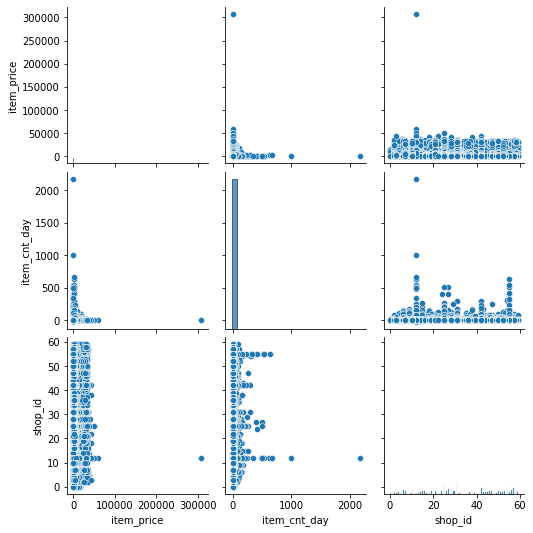

In [16]:
dqc.pairplot(['item_price','item_cnt_day', 'shop_id'])

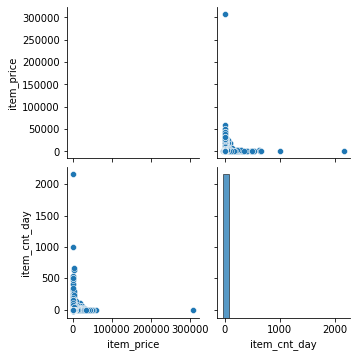

In [17]:
dqc.pairplot(['item_price','item_cnt_day'])

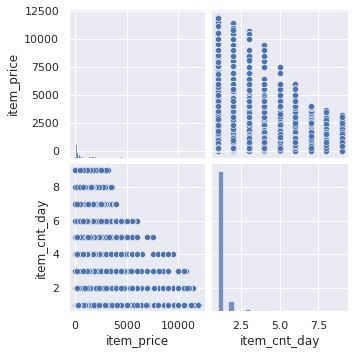

In [32]:
dqc.pairplot(['item_price','item_cnt_day'])

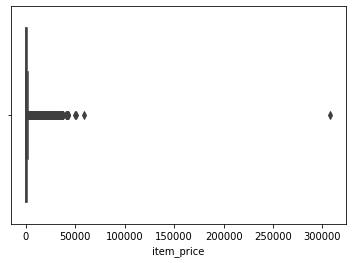

In [18]:
dqc.boxplot('item_price')

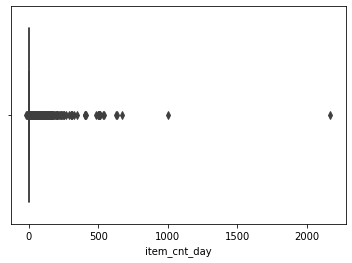

In [19]:
dqc.boxplot('item_cnt_day')

In [20]:
dqc.fix_feature_by_low_up_value(feature_name='item_cnt_day', low_vlaue=0)#, up_value=600)
dqc.fix_feature_by_low_up_value(feature_name='item_price', low_vlaue=0)#, up_value=50000)

Full data : 2935849
item_cnt_day < 0 : 7356
Full data : 2928493
item_price < 0 : 1


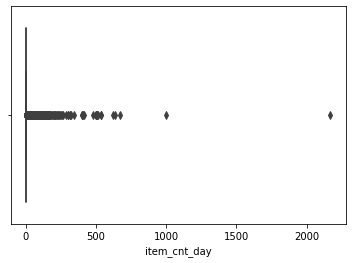

In [21]:
dqc.boxplot('item_cnt_day')

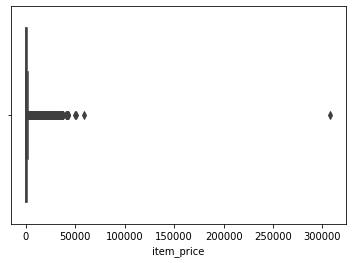

In [22]:
dqc.boxplot('item_price')

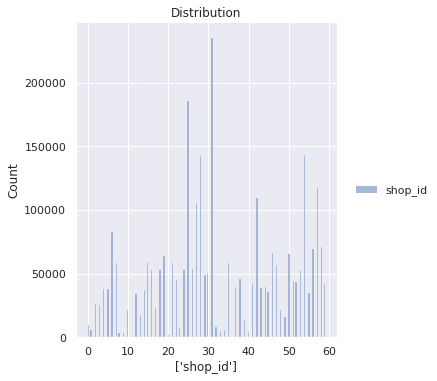

In [23]:
dqc.plot_feature(feature_name=['shop_id'])

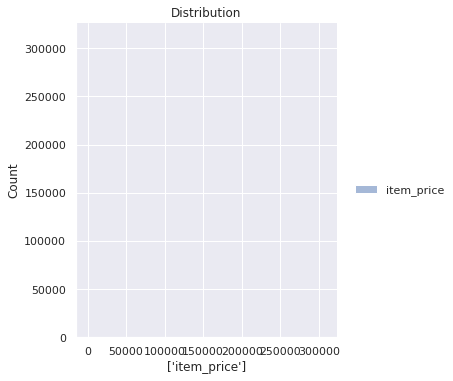

In [24]:
dqc.plot_feature(feature_name=['item_price'])

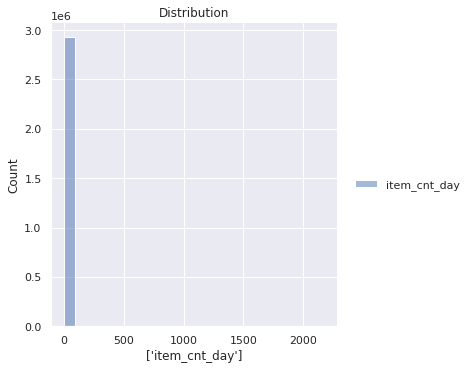

In [25]:
dqc.plot_feature(feature_name=['item_cnt_day'])

In [26]:
dqc.isolation_forest(feature_name_list=['item_price','item_cnt_day'], contamination=0.01)
dqc.lof(feature_name_list=['item_cnt_day','item_price'], n_neighbors=7 ,contamination=0.001)

Full data : 2928492
Marked as outliers : 29009
Full data : 2899483
Marked as outliers : 2900


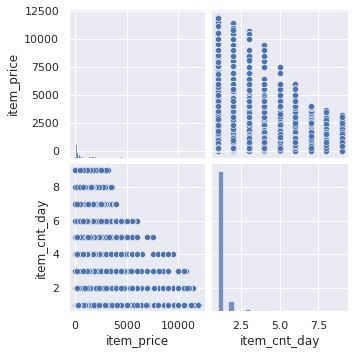

In [27]:
dqc.pairplot(['item_price','item_cnt_day'])

In [28]:
data = dqc.get_data()

In [29]:
from numpy import asarray
from numpy import savetxt
data.to_csv('new_test.csv',index=False)

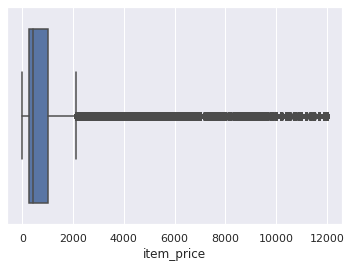

In [30]:
dqc.boxplot('item_price')

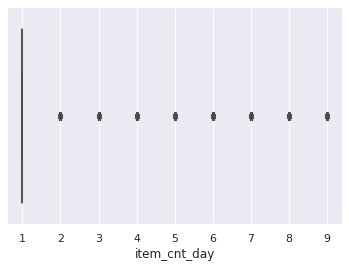

In [31]:
dqc.boxplot('item_cnt_day')